In [1]:
import base64
import io
import pickle
import numpy as np
import math
import torch
print(f'TORCH VERSION: {torch.__version__}')
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
    raise RuntimeError('Torch versions lower than 1.5.0 not supported')
%matplotlib inline
import matplotlib.pyplot as plt


TORCH VERSION: 2.0.0+cu117


Code is an amalgamation of https://arxiv.org/pdf/2101.08176 and https://github.com/TinyVolt/normalizing-flows/blob/main/1d_composing_flows/ComposableFlows1d.ipynb

In [2]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
    print(f"TORCH DEVICE: {torch_device}")

In [3]:
def grab(var):
    return var.detach().cpu().numpy()

## Define a prior distribution


Standard normal

In [4]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(
        torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape
    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)
    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)

# Define the flow

Very simple 1-dimensional layers


In [5]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal 

class Flow1d(nn.Module):
    def __init__(self, n_components):
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.ones(n_components), requires_grad=True)

    def forward(self, x):
        x = x.view(-1,1)
        weights = self.weight_logits.softmax(dim=0).view(1,-1)
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = (distribution.cdf(x) * weights).sum(dim=1)
        log_dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1).log()
        return z, log_dz_by_dx

class LogitTransform(nn.Module):
    def __init__(self, alpha):
        super(LogitTransform, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        x_new = (self.alpha/2 + (1-self.alpha)*x).to(torch_device)
        z = torch.log(x_new) - torch.log(1-x_new)
        log_dz_by_dx = torch.log(torch.FloatTensor([1-self.alpha]).to(torch_device)) - torch.log(x_new) - torch.log(1-x_new)
        return z, log_dz_by_dx
        

class FlowComposable1d(nn.Module):
    def __init__(self, flow_models_list):
        super(FlowComposable1d, self).__init__()
        self.flow_models_list = nn.ModuleList(flow_models_list).to(torch_device)

    def forward(self, x):
        z, sum_log_dz_by_dx = x, 0
        for flow in self.flow_models_list:
            z, log_dz_by_dx = flow(z)
            sum_log_dz_by_dx += log_dz_by_dx
        return z, sum_log_dz_by_dx

In [6]:
# Loss function

def calc_dkl(logp, logq):
    return (logq - logp).mean() # reverse KL, assuming samples from q

# Define the probability density 

In [7]:
E0 = 500


def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def target_logp_order1(x): # 1st order approximation to the function

    alpha_s_scale = alpha_s(x * E0) # GeV
    C_F = 4/3
    C_A = 3
    
    p_order1 = -(alpha_s_scale * C_F / (1 * np.pi)) * torch.log(x ) / x
        
    p_order1[x < 0.01] = 0
        
    log_p_order1 = torch.log(p_order1)
        
    

    return torch.nan_to_num(log_p_order1, nan = 0.0)

"""
# toy model
def target_logp_order1(x): # 1st order approximation to the function

    target_p = 1.5*(-x**2 + 1)

    return torch.log(target_p)
"""

'\n# toy model\ndef target_logp_order1(x): # 1st order approximation to the function\n\n    target_p = 1.5*(-x**2 + 1)\n\n    return torch.log(target_p)\n'

In [8]:
# Training hyperparams
num_epochs = 100
lr = .01
batch_size = 512

# Initialize the prior
num_points = 50 # we define a prior on each point along the horizontal axis
                # eventually this should be made large
prior = SimpleNormal(torch.zeros(num_points), torch.ones(num_points))

# Initialize the model
# Model archutecture not optimized at all
flow_models_list = [Flow1d(2), LogitTransform(0.1), Flow1d(2), LogitTransform(0.1), Flow1d(2)]
flow = FlowComposable1d(flow_models_list)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)


In [9]:
train_losses = []

for epoch in range(num_epochs):
    
    
    optimizer.zero_grad()
    
    # APPLY FLOW TO PRIOR
    # draw samples from prior
    x = prior.sample_n(batch_size).to(torch_device) # shape x: (batch_size, num_points)
    logq = prior.log_prob(x) # shape logq: (batch_size)
    
    x, logJ = flow(x)
    # need to reshape the outputs match those from the previous step
    x = x.reshape(batch_size, num_points) 
    logJ = torch.sum(logJ.reshape(batch_size, num_points), dim=1)
    logq = logq - logJ 
        
    # CALCULATE THE TARGET
    logp = torch.sum(target_logp_order1(x), dim=1)
    loss = calc_dkl(logp, logq)
     
    loss.backward()
    optimizer.step()
        
    train_losses.append(grab(loss))

   

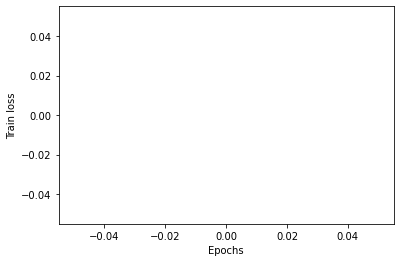

In [10]:
plt.figure()
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Train loss")
plt.show()

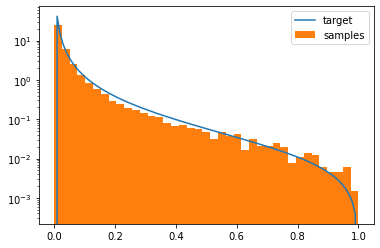

In [11]:
# plot output

x_test = torch.linspace(0, 1, 100)


plt.figure()

# plot the target
plt.plot(grab(x_test), np.exp(grab(target_logp_order1(x_test.to(torch_device)))), label = "target")

# plot transformed prior
x = prior.sample_n(batch_size).to(torch_device) # shape x: (batch_size, num_points)    
x, logJ = flow(x)
# need to reshape the outputs match those from the previous step
x = grab(x.reshape(-1,1) )
plt.hist(x, bins = np.linspace(0, 1, 40), density = True, label = "samples")

plt.yscale("log")
plt.legend()
plt.show()

